In [13]:
import os
import re
import time
import spacy
import random
import tarfile
import itertools
import numpy as np
import seaborn as sns
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt

from lazy import lazy
from colors import color
from attrdict import AttrDict
from bn_lstm import BNLSTMCell
from collections import defaultdict
from HanSequenceLabellingModel import HanSequenceLabellingModel

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)

%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



## Imdb reviews

In [2]:
class ImdbMovieReviews:
    DEFAULT_URL = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    TOKEN_REGEX = re.compile(r"[A-Za-z]+|[!?.:,()]")
    
    def __init__(self):
        self._cache_dir = "./imdb"
        self._url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
            
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            
            for filename in archive.getnames():
                if filename.startswith("aclImdb/train/pos/"):
                    yield self._read(archive, filename), True
                elif filename.startswith("aclImdb/train/neg/"):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode("utf-8")
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

## Embedding

In [3]:
class Embedding:
    def __init__(self):
        self.parser = spacy.load("en_vectors_web_lg")
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        data = np.zeros((length, self.dimensions))
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == ".") if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [5]:
reviews = list(ImdbMovieReviews())
random.shuffle(reviews)

## HAN model

In [10]:
def HAN_model(session, restore_only=False):
    """Hierarhical Attention Network"""
    
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel
    
    is_training = tf.placeholder(dtype=tf.bool, name="is_training")

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = "checkpoints"
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

## Attention

In [49]:
def visualize(sents, sent_atts, word_atts):
    min_sent_att, max_sent_att = np.min(sent_atts), np.max(sent_atts)
    
    for i, sent in enumerate(sents):
        sent_value = (sent_atts[i] - min_sent_att) / (max_sent_att - min_sent_att)
        sent_color = (55, 55, 55 + int(200 * sent_value))
        print(color("  ", bg=sent_color), end="")
        
        min_word_att, max_word_att = np.min(word_atts[i, : len(sent)]), np.max(word_atts[i, : len(sent)])
            
        for j, word in enumerate(sent):
            if max_word_att - min_word_att > 1e-5:
                word_value = (word_atts[i, j] - min_word_att) / (max_word_att - min_word_att)
            else:
                word_value = 1.0
            
            word_color = (55 + int(200 * word_value), 55, 55)
            print(color(word, word_color), end=" ")
        
        print()

In [51]:
tf.reset_default_graph()

batches_split = preprocess_batched_split(reviews, Embedding(), batch_size=10)

config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as session:
    model, saver = HAN_model(session)
    
    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch = next(batches_split)
    
    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }
    
    sent_atts, word_atts = session.run([model.sentence_level_output, model.word_level_output],
                                       feed_dict=fd)
    
    sent = sents_batch[0]
    sent_att = sent_atts[0, :len(sent)]
    word_att = word_atts[:len(sent), :]
    
    visualize(sent, sent_att, word_att)

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
  according to the book the last of the cowboy heroes which is about joel mccrea , audie murphy , and randolph scott , the author says that albuquerque was the only film he personally did not review because he claimed it was lost 
  hadn t been seen in years 
  br br good thing for western fans somebody was doing some spring cleaning at paramount because a print was apparently found and now it s out on the open market 
  albuquerque is a pretty good western too with scott involved in a family feud with uncle george cleveland 
  br br george cleveland sends for his nephew randolph scott with the intention of making him part of his freighting business , headquartered in the fast growing settlement of albuquerque 
  cleveland is more than just a business owner , he s the town boss which he runs from a wheelchair 
  he even has the sheriff in his pocket 
  br br r

## Attention weight distribution

In [52]:
tf.reset_default_graph()

batches_split = preprocess_batched_split(reviews, Embedding(), batch_size=10)

iter_step = 100
iter_count = 300

count = defaultdict(list)

config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as session:
    model, saver = HAN_model(session)
    
    for it, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split, 1):
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        sent_atts, word_atts = session.run([model.sentence_level_output, model.word_level_output],
                                           feed_dict=fd)

        i = 0

        for sents, label in zip(sents_batch, labels_batch):
            for sent in sents:
                for j, word in enumerate(sent):
                    if word == "good" or word == "bad":
                        count[(word, label)].append(word_atts[i, j])
                i += 1
            i += 1  
    
        if it % iter_step == 0:
            print("Iteration {}".format(it))
            
        if it == iter_count:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
Iteration 100
Iteration 200
Iteration 300


### Plot distribution

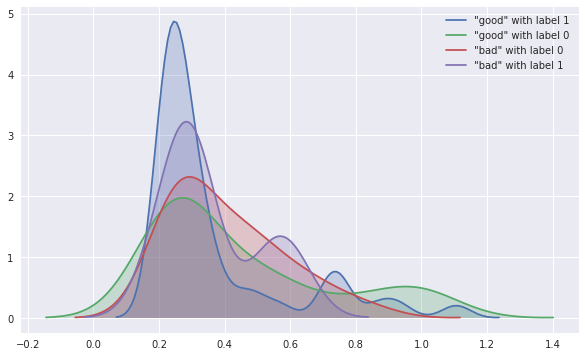

In [53]:
min_value = 0.2

for (word, label), values in count.items():
    x = np.array(values)
    sns.kdeplot(x[x >= min_value], shade=True, label="\"{}\" with label {}".format(word, label))

## HAN accuracy

In [40]:
tf.reset_default_graph()

batches_split = preprocess_batched_split(reviews, Embedding(), batch_size=10)

iter_step = 10
iter_count = 100

config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as session:
    model, saver = HAN_model(session)
    
    total_accuracy = 0
    
    for it, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split, 1):
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        accuracy = session.run([model.accuracy], feed_dict=fd)
        total_accuracy += accuracy[0]
        
        if it % iter_step == 0:
            print("Iteration {}: accuracy = {:3.1f}%".format(it, 100 * total_accuracy / iter_step))
            total_accuracy = 0
        
        if it == iter_count:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
Iteration 10: accuracy = 82.0%
Iteration 20: accuracy = 84.0%
Iteration 30: accuracy = 88.0%
Iteration 40: accuracy = 86.0%
Iteration 50: accuracy = 81.0%
Iteration 60: accuracy = 85.0%
Iteration 70: accuracy = 87.0%
Iteration 80: accuracy = 74.0%
Iteration 90: accuracy = 89.0%
Iteration 100: accuracy = 83.0%


## SequenceClassificationModel accuracy

In [33]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self.global_step = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def load(self, folder):
        saver = tf.train.Saver()

        if os.path.isdir(folder):
            saver.restore(self.sess, tf.train.latest_checkpoint(folder))
        else:
            raise RuntimeError("Checkpoint is not found!")
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 2])
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant
    
    def test(self, batches, iter_step, iter_count):
        total_accuracy = 0
        
        for it, batch in enumerate(batches, 1):
            feed = {model.data: batch[0], model.target: batch[1]}
            error = self.sess.run([model.error], feed)
            total_accuracy += (1.0 - error[0])
            
            if it % iter_step == 0:
                print("Iteration {}: accuracy = {:3.1f}%".format(it, 100 * total_accuracy / iter_step))
                total_accuracy = 0
                
            if it == iter_count:
                break
            
    def close(self):
        tf.reset_default_graph()
        self.sess.close()

In [21]:
def preprocess_batched(iterator, length, embedding, batch_size):
    iterator = iter(iterator)
    
    while True:
        data = np.zeros((batch_size, length, embedding.dimensions))
        target = np.zeros((batch_size, 2))
  
        for index in range(batch_size):
            text, label = next(iterator)
            data[index] = embedding(text, length)
            target[index] = [1, 0] if label else [0, 1]
            
        yield data, target

In [22]:
length = max(len(x[0]) for x in reviews)
embedding = Embedding()

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=300,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=20,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embedding.dimensions
)

In [23]:
batches = preprocess_batched(reviews, length, embedding, params.batch_size)

In [38]:
tf.reset_default_graph()

In [39]:
iter_step = 10
iter_count = 100

model = SequenceClassificationModel(params)
model.load("./no_att_checkpoints/")
model.test(batches, iter_step, iter_count)
model.close()

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ./no_att_checkpoints/simple-rnn-1240
Iteration 10: accuracy = 87.0%
Iteration 20: accuracy = 86.5%
Iteration 30: accuracy = 88.5%
Iteration 40: accuracy = 86.0%
Iteration 50: accuracy = 91.0%
Iteration 60: accuracy = 84.5%
Iteration 70: accuracy = 88.0%
Iteration 80: accuracy = 87.5%
Iteration 90: accuracy = 91.0%
Iteration 100: accuracy = 86.0%
